### Bootstrapping, the right way.

Approach:

Let $W^{(k)}$ be the estimated matrix of OMP using $k$ coefficients. How do we know which value we should pick for $k$? Bootstrapping.

Let $k$ be any iteration. We get a matrix $W^{(k)}$. We will sample according to this estimated matrix, and we will get a matrix $\hat{W}^{(k)}$. If $W^{(k)}$ is good, then $W^{(k)}$ and $\hat{W}^{(k)}$ should coincide. We pick the $k$ such that the difference is minimal.

### Generate Data

In [3]:
# standard libraries
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
import helper.helper as h
import helper.methods as m

from importlib import reload  # Python 3.4+

In [20]:
# reload helper and methods for when things change
reload(m);
reload(h);

True W:
[[ 0.5   0.    0.    0.    0.  ]
 [-0.44  0.5   0.    0.    0.  ]
 [ 0.    0.    0.5   0.    0.  ]
 [ 0.58  0.    0.    0.5   0.  ]
 [ 0.    0.55  0.   -0.61  0.5 ]].



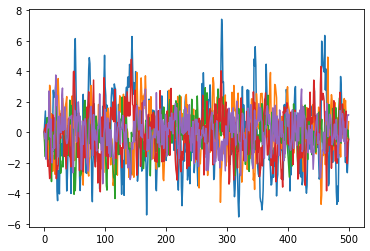

In [193]:
np.random.seed(seed = 123456)

## Number of dimensions, number of edges, number of samples
T, n, s = 500, 5, 5

### Coefficient matrix
## First approach: A is a DAG, no model mismatch
A_true = h.generate_A(n, s, tril = False, low = 0.30, high = 0.70)

# set coefficients to be positive (else oscillating which does not make sense)
for i in range(len(A_true)):
    A_true[i][i] = 0.5 # np.abs(A_true[i][i])

s = len(A_true.flatten().nonzero()[0])

## True permutation
P_true = np.identity(n) # np.random.permutation(np.identity(n))

## Datagenerating W
W_true = P_true.T @ A_true @ P_true
print(f"True W:\n{np.round(W_true, 2)}.\n")

## Generate series
X = h.generate_var_2(T, n, A_true, P_true)
plt.plot(X);

What we do: 
1. Compute $\{W_k\}_{k = 1}^{K}$. 
2. Generate $\hat{X}_{W_k}$ using $W_k$ of length $T$.

### Approach 1:
Compare MSE($W^{(k)}, X$) to MSE($\hat{W}^{(k)}, \hat{X}_{W_k}$).

### Approach 2:
Compare 

W^(1):
[[ 0.    0.    0.    0.    0.  ]
 [-0.93  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]].

\hat(W)^(1):
[[ 0.    0.    0.    0.    0.  ]
 [-0.96  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]].

W^(2):
[[ 0.    0.    0.    0.    0.  ]
 [-0.93  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.76  0.  ]
 [ 0.    0.    0.    0.    0.  ]].

\hat(W)^(2):
[[ 0.    0.    0.    0.    0.  ]
 [-0.8   0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.69  0.  ]
 [ 0.    0.    0.    0.    0.  ]].

W^(3):
[[ 0.    0.    0.    0.    0.  ]
 [-0.93  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.76  0.  ]
 [ 0.    0.69  0.    0.    0.  ]].

\hat(W)^(3):
[[ 0.    0.    0.    0.    0.  ]
 [-0.72  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]
 

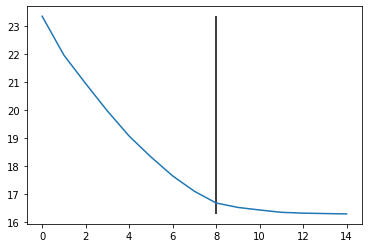

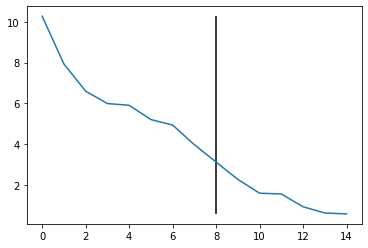

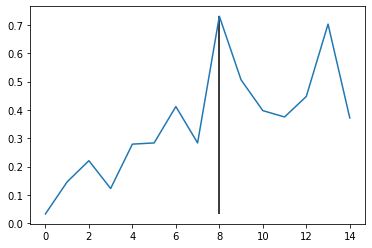

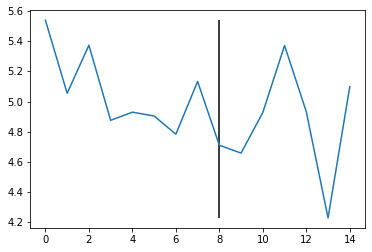

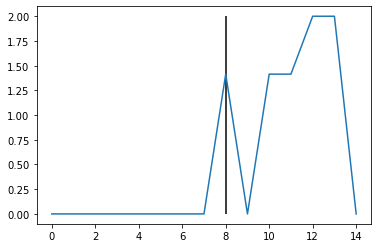

In [189]:
W, Ws, mses, max_gains = m._OMP_2(X[:-1], X[1:], output = True)

bootstrap_Ws = []
bootstrap_mses = []
diff = []
diff_bin = []

for i, W in enumerate(Ws):
    print(f"W^({i+1}):\n{np.round(W, 2)}.\n")
    
    # generate data according to W
    X_W = h.generate_var_2(T, n, W, np.identity(n))
    
    mse = h.MSE(W, X_W)
    
    # bootstrap, get \hat{W}_k
    _, bootstrap_Ws_i, _, _ = m._OMP_2(X_W[:-1], X_W[1:], output = True)
    bootstrap_Ws.append(bootstrap_Ws_i)
    
    bootstrap_W_ii = bootstrap_Ws_i[i]
    print(f"\hat(W)^({i+1}):\n{np.round(bootstrap_W_ii, 2)}.\n")
    
    # compare OMP and Bootstrap
    bootstrap_mses.append(h.MSE(bootstrap_W_ii, X_W))
    
    # difference
    W_bin = W != 0
    W_bootstrap_bin = bootstrap_W_ii != 0
    
    
    diff_bin.append(np.linalg.norm(W_bin ^ W_bootstrap_bin))
    
    # check numerical differences between the two
    diff.append(np.linalg.norm(bootstrap_W_ii - W))

plt.vlines(s - 1, min(mses), max(mses))
plt.plot(mses)
plt.show()
plt.vlines(s - 1, min(max_gains), max(max_gains))
plt.plot(max_gains)
plt.show()
plt.vlines(s - 1, min(diff), max(diff))
plt.plot(diff)
plt.show()
plt.vlines(s - 1, min(bootstrap_mses), max(bootstrap_mses))
plt.plot(bootstrap_mses)
plt.show()
plt.vlines(s - 1, min(diff_bin), max(diff_bin))
plt.plot(diff_bin)

### Approach 2, compare entries.

### Issues
- If we sample for long enough, then we have $\underset{T \rightarrow \infty}{\lim} \texttt{OMP}(X_{W_k}(T), k) = W^{(k)}$. Then, what do we do?

### Approaches:
- Regularization.
    - Decrease in MSE, should be above threshold.
    - Decrease in gain, should be above threshold.
- Bootstrapping. Sample $X_k$ according to $W_k$, and compare $\hat{W}_k$ with respect to:
    - Difference in norm (0-norm, 2-norm, etc.)
    - 
- Validation.
    - Split in half, validate OMP, trained on first half, on second half.

### Nested Bootstrap:
Given $X$, estimate $W_1, \ldots, W_K$.

for $i = 1$ until $K$:
1. Sample $X_{W_i}$ using $W_i$.
2. Given $X_{W_i}$, estimate $\hat{W}_{i, 1}, \ldots, \hat{W}_{i,K}$.

Which $k$ should be pick? 

Pick the $k$ such that $\hat{W}_{\cdot, k}$ is closest to $W_k$.

(15, 15, 5, 5)
[[ 0.          0.          0.          0.          0.        ]
 [-0.16332675  0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.51842514  0.          0.          0.2063904   0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.          0.          0.          0.          0.        ]
 [-0.93185221  0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.          0.          0.          0.          0.        ]
 [-0.26471121  0.04640704  0.          0.          0.        ]
 [ 0.          0.          0.04670555  0.          0.02219715]
 [ 0.61358797  0.          0.          0.3511722   0.        ]
 [ 0.          0.25576978  0.         -0.04826972  0.        ]]
[[ 0.          0.          0.        

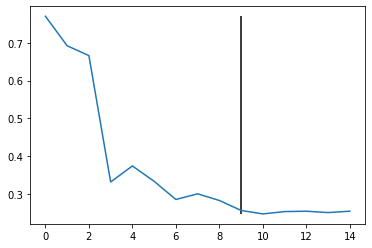

In [190]:
W_np = np.array(bootstrap_Ws)

norms = []
print(np.shape(W_np))
W_avg = np.average(W_np, axis = 0)

for i, W in enumerate(W_avg):
    print(W)
    print(Ws[i])
    
    norms.append(np.linalg.norm(W.flatten() - Ws[i].flatten(), 10))

plt.vlines(len(W_true.nonzero()[0]), min(norms), max(norms))
plt.plot(norms)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 

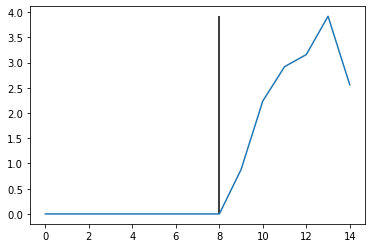

In [196]:
W, Ws, mses, max_gains = m._OMP_2(X[:-1], X[1:], output = True)

diff_bin_avg = []
diff_avg = []

for i, W in enumerate(Ws):
    print(i, end = ", ")
    diff_bin = []
    diff = []
    
    for j in range(50):
        # generate data according to W
        X_W = h.generate_var_2(T, n, W, np.identity(n))
    
        # bootstrap, get \hat{W}_k
        _, bootstrap_Ws_i, _, _ = m._OMP_2(X_W[:-1], X_W[1:], output = True)
        bootstrap_W_ii = bootstrap_Ws_i[i]
    
        # difference
        W_bin = W != 0
        W_bootstrap_bin = bootstrap_W_ii != 0
        
        diff_bin.append(np.linalg.norm((W_bin ^ W_bootstrap_bin).flatten(), 0))
        diff.append(np.linalg.norm(W.flatten() - bootstrap_W_ii.flatten(), 100))
    
    diff_bin_avg.append(np.sum(diff_bin) / np.shape(diff_bin)[0])
    # diff_avg.append(np.sum(diff) / np.shape(diff)[0])
    
plt.vlines(s - 1, min(diff_bin_avg), max(diff_bin_avg))
plt.plot(diff_bin_avg)

# plt.vlines(s - 1, min(diff_avg), max(diff_avg))
# plt.plot(diff_avg)